# Binary Image creation

A method or combination of methods (i.e., color transforms, gradients) has been used to create a binary image containing likely lane pixels

load all the library

In [4]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

Below code will convert threshold a color frame in HSV space

In [5]:
def thresholdHSV(frame, min_values, max_values):
    """
    Threshold a color frame in HSV space
    """
    HSV = cv2.cvtColor(frame, cv2.COLOR_RGB2HLS)

    min_th_ok = np.all(HSV > min_values, axis=2)
    max_th_ok = np.all(HSV < max_values, axis=2)

    out = np.logical_and(min_th_ok, max_th_ok)
    return out

Below function Apply Sobel edge detection to an input frame, then threshold the result

In [6]:
def thresholdSobel(frame, kernel_size):
    """
    Apply Sobel edge detection to an input frame, then threshold the result
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)

    sobel_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    sobel_mag = np.uint8(sobel_mag / np.max(sobel_mag) * 255)

    _, sobel_mag = cv2.threshold(sobel_mag, 50, 1, cv2.THRESH_BINARY)

    return sobel_mag.astype(bool)

Below function apply histogram equalization to an input frame, threshold it and return the (binary) result.

In [7]:
def getBinaryFromGrayscale(frame):
    """
    Apply histogram equalization to an input frame, threshold it and return the (binary) result.
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    eq_global = cv2.equalizeHist(gray)

    _, th = cv2.threshold(eq_global, thresh=250, maxval=255, type=cv2.THRESH_BINARY)

    return th

Below funciton will return the all binary image-Convert an input frame to a binary image which highlight as most as possible the lane-lines

In [8]:
def binaryImage(img):
    """
    Convert an input frame to a binary image which highlight as most as possible the lane-lines.
"""
    yellow_HSV_th_min = np.array([0, 70, 70])
    yellow_HSV_th_max = np.array([50, 255, 255])
    
    binary_Images = []
    h, w = img.shape[:2]
    binary_Images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    binary = np.zeros(shape=(h, w), dtype=np.uint8)

    # highlight yellow lines by threshold in HSV color space
    HSV_yellow_mask = thresholdHSV(img, yellow_HSV_th_min, yellow_HSV_th_max)
    binary = np.logical_or(binary, HSV_yellow_mask)

    # highlight white lines by thresholding the equalized frame
    eq_white_mask = getBinaryFromGrayscale(img)
    binary_Images.append(eq_white_mask)
    binary = np.logical_or(binary, eq_white_mask)
    binary_Images.append(HSV_yellow_mask)

    # get Sobel binary mask (thresholded gradients)
    sobel_mask = thresholdSobel(img, kernel_size=9)
    binary_Images.append(sobel_mask)
    binary = np.logical_or(binary, sobel_mask)
    binary_Images.append(binary)

    # apply a light morphology to "fill the gaps" in the binary image
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    binary_Images.append(closing)

    return binary_Images

Below funciton will show all possibale image of avialbe into test images


In [9]:
def showImages(images, cmap=None):
    for i in range(len(images)):
        for j in range(len(images[i])):
            f, ax = plt.subplots(2,3)
            f.set_facecolor('white')
            ax[0, 0].imshow(images[i][j])
            ax[0, 0].set_title('input_frame')
            ax[0, 0].set_axis_off()
            j = j + 1
            ax[0, 1].imshow(images[i][j], cmap='gray')
            ax[0, 1].set_title('white mask')
            ax[0, 1].set_axis_off()
            j = j + 1
            ax[0, 2].imshow(images[i][j], cmap='gray')
            ax[0, 2].set_title('yellow mask')
            ax[0, 2].set_axis_off()
            j = j + 1
            ax[1, 0].imshow(images[i][j], cmap='gray')
            ax[1, 0].set_title('sobel mask')
            ax[1, 0].set_axis_off()
            j = j + 1
            ax[1, 1].imshow(images[i][j], cmap='gray')
            ax[1, 1].set_title('before closure')
            ax[1, 1].set_axis_off()
            j = j + 1
            ax[1, 2].imshow(images[i][j], cmap='gray')
            ax[1, 2].set_title('after closure')
            ax[1, 2].set_axis_off()
            break
        plt.show()

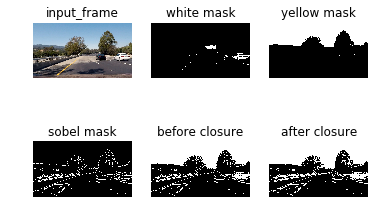

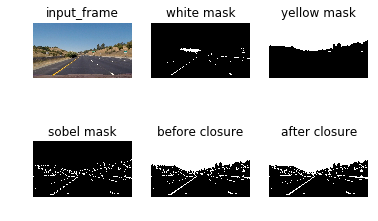

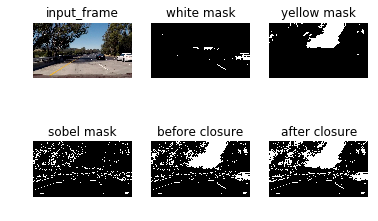

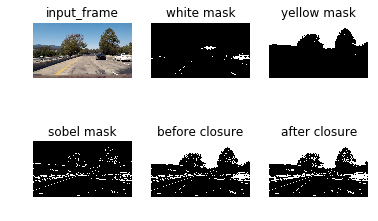

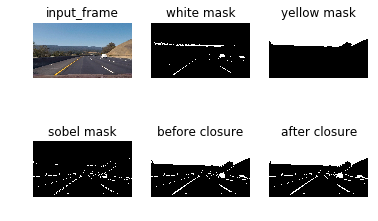

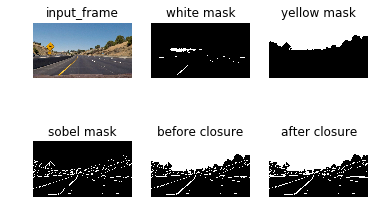

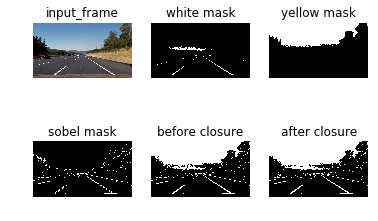

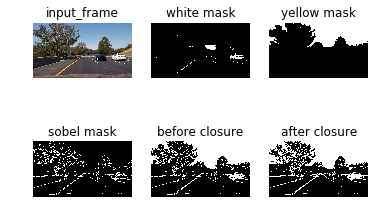

In [10]:
    final_images = []
    test_images = glob.glob('test_images/*.jpg')
    for test_image in test_images:
        img = cv2.imread(test_image)
        final_images.append(binaryImage(img=img))
    
    showImages(final_images)